In [1]:
%cd ../
%matplotlib inline

/home/eli/AnacondaProjects/HTFATorch


In [2]:
# import dependencies
import logging
import numpy as np

import htfa_torch.tfa as TFA
import htfa_torch.utils as utils

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s',
                            datefmt='%m/%d/%Y %H:%M:%S',
                            level=logging.INFO)

In [4]:
tfa = TFA.TopographicalFactorAnalysis('data/pieman_data/sub-001-task-intact1.nii', num_factors=25)

In [5]:
prior_sample = tfa.sample()

logging.info('Prior Reconstruction Error (Frobenius Norm): %.8e', np.linalg.norm(
    prior_sample['Y0'].value.data.cpu().numpy() - tfa.voxel_activations.numpy()
))

prior_sample

del prior_sample

05/04/2018 13:03:33 Prior Reconstruction Error (Frobenius Norm): 5.34985840e+03


In [6]:
losses = tfa.train(num_steps=100, log_level=logging.INFO, batch_size=tfa.voxel_activations.shape[0], num_particles=4, use_cuda=True)

05/04/2018 13:03:35 [Epoch 1] (320ms) Posterior free-energy 7.88073933e+09
05/04/2018 13:03:35 [Epoch 2] (265ms) Posterior free-energy 5.42158746e+09
05/04/2018 13:03:36 [Epoch 3] (263ms) Posterior free-energy 1.22712320e+10
05/04/2018 13:03:36 [Epoch 4] (263ms) Posterior free-energy 4.60946586e+09
05/04/2018 13:03:36 [Epoch 5] (260ms) Posterior free-energy 4.71702221e+09
05/04/2018 13:03:36 [Epoch 6] (277ms) Posterior free-energy 4.20022579e+09
05/04/2018 13:03:37 [Epoch 7] (242ms) Posterior free-energy 3.69151181e+09
05/04/2018 13:03:37 [Epoch 8] (289ms) Posterior free-energy 6.52128205e+09
05/04/2018 13:03:37 [Epoch 9] (230ms) Posterior free-energy 3.44719718e+09
05/04/2018 13:03:37 [Epoch 10] (228ms) Posterior free-energy 3.32032486e+09
05/04/2018 13:03:38 [Epoch 11] (261ms) Posterior free-energy 2.43177139e+09
05/04/2018 13:03:38 [Epoch 12] (267ms) Posterior free-energy 2.67225677e+09
05/04/2018 13:03:38 [Epoch 13] (312ms) Posterior free-energy 2.28406579e+09
05/04/2018 13:03:38 [

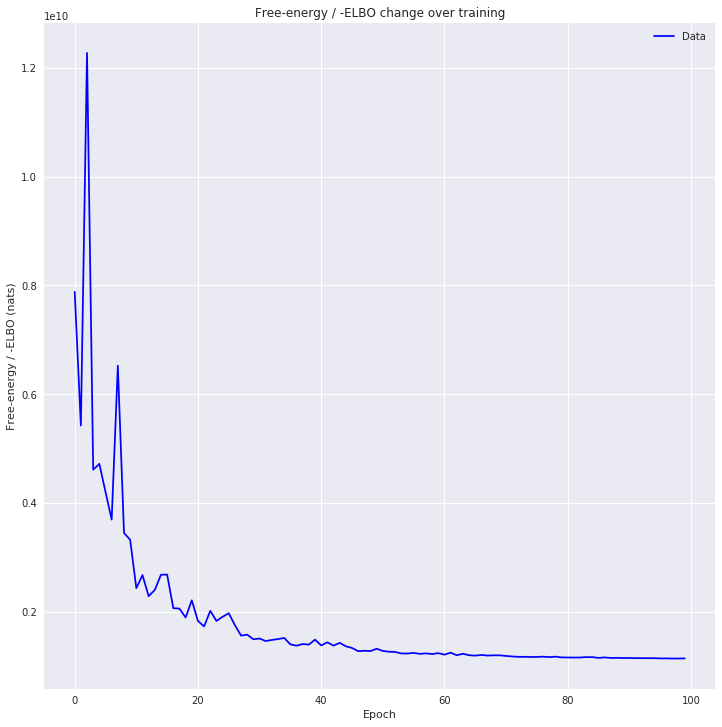

05/04/2018 13:04:01 Reconstruction Error (Frobenius Norm): 4.84726074e+03
05/04/2018 13:04:01 {'weights': array([[-0.82634336,  2.0404212 ,  1.0563704 , ...,  0.57666016,
        -1.9695898 ,  0.4948914 ],
       [-1.4931477 ,  0.68722546,  1.7647474 , ...,  0.2641073 ,
         0.21545522,  1.2596195 ],
       [-2.2496536 ,  0.06423336,  1.8250843 , ..., -1.3106743 ,
         0.7471676 ,  1.8181318 ],
       ...,
       [-4.420024  ,  0.36879975,  1.2303303 , ..., -0.7640382 ,
         0.35828954,  0.15721905],
       [-5.0094423 ,  0.32246956,  2.6692348 , ..., -0.56999743,
        -0.30556485, -0.98316747],
       [-6.0557528 ,  0.8192271 ,  4.269798  , ...,  1.9704199 ,
         0.7415675 , -2.579471  ]], dtype=float32), 'factors': array([[3.7000617e-03, 3.9295708e-03, 4.1477415e-03, ..., 3.0956033e-03,
        3.4533096e-03, 3.6454552e-03],
       [6.2744104e-05, 6.0696108e-05, 5.8123409e-05, ..., 5.8147794e-01,
        6.0995579e-01, 5.6483978e-01],
       [2.4205988e-04, 2.42132

In [7]:
utils.plot_losses(losses)

results = tfa.results()
logging.info(results)

In [8]:
posterior_sample = tfa.sample(posterior_predictive=True)

logging.info('Prior Reconstruction Error (Frobenius Norm): %.8e', np.linalg.norm(
    posterior_sample['Y0'].value.data.cpu().numpy() - tfa.voxel_activations.numpy()
))

posterior_sample

05/04/2018 13:04:02 Prior Reconstruction Error (Frobenius Norm): 4.88486475e+03


Trace{'Weights0': Normal([torch.FloatTensor of size 1x300x25]), 'FactorCenters0': Normal([torch.FloatTensor of size 1x25x3]), 'FactorLogWidths0': Normal([torch.FloatTensor of size 1x25]), 'Y0': Normal([torch.FloatTensor of size 1x300x94537])}

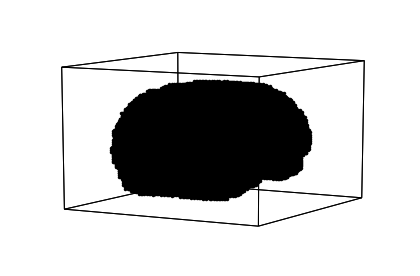

05/04/2018 13:04:03 Reconstruction Error (Frobenius Norm): 4.84760449e+03


> /home/eli/AnacondaProjects/HTFATorch/htfa_torch/tfa.py(258)plot_factor_centers()
-> palette = utils.uncertainty_palette(uncertainties)
> /home/eli/AnacondaProjects/HTFATorch/htfa_torch/tfa.py(260)plot_factor_centers()
-> plot = niplot.plot_connectome(
array([[0.4       , 0.76078431, 0.64705882, 0.9873873 ],
       [0.4       , 0.76078431, 0.64705882, 0.98604637],
       [0.4       , 0.76078431, 0.64705882, 0.97732157],
       [0.98823529, 0.55294118, 0.38431373, 0.99125612],
       [0.98823529, 0.55294118, 0.38431373, 0.97536147],
       [0.98823529, 0.55294118, 0.38431373, 0.99184769],
       [0.55294118, 0.62745098, 0.79607843, 0.98676032],
       [0.55294118, 0.62745098, 0.79607843, 0.98288912],
       [0.55294118, 0.62745098, 0.79607843, 0.99528527],
       [0.90588235, 0.54117647, 0.76470588, 0.99144518],
       [0.90588235, 0.54117647, 0.76470588, 0.95972306],
       [0.90588235, 0.54117647, 0.76470588, 0.99663037],
       [0.65098039, 0.84705882, 0.32941176, 0.98307997],
     

/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/nilearn/plotting/displays.py:1291: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':


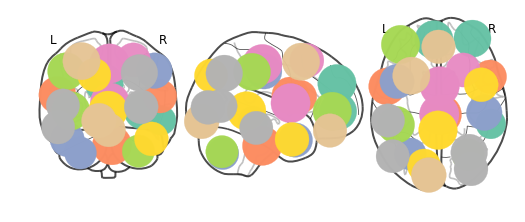

In [9]:
tfa.plot_voxels()
tfa.plot_factor_centers()

/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


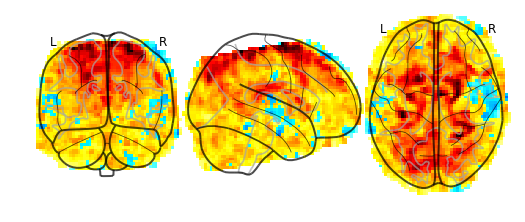

05/04/2018 13:04:25 Reconstruction Error (Frobenius Norm): 4.85198633e+03


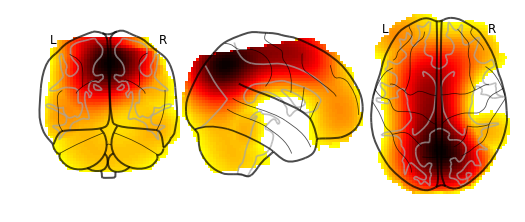

In [10]:
tfa.plot_original_brain()
tfa.plot_reconstruction()

05/04/2018 13:04:38 Reconstruction Error (Frobenius Norm): 4.84938916e+03
/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/nilearn/plotting/displays.py:1291: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':


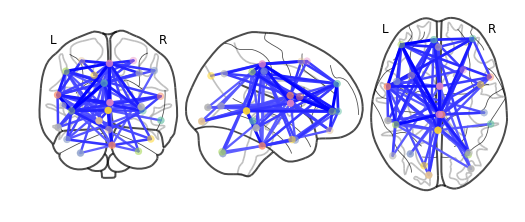

In [11]:
tfa.plot_connectome()